# Получение данных со strava heatmap


In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.misc import imread,imsave
import requests as r
import math
import pandas as pd

def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.144])

def getTile(x, y, z, color=3):
    """
        return np.array for strava heatmap tile
    """
    # http://globalheat.strava.com/tiles/cycling/color4/13/4948/2560.png
    assert 0 <= color < 8, "Color should be between 0 and 8"
    url = "http://globalheat.strava.com/tiles/cycling/color%d/%d/%d/%d.png" % (color, z, x, y)

    ret = r.get(url)
    filename = 'tmp.png'
    chunk_size=1024
    with open(filename, 'wb') as fd:
        for chunk in ret.iter_content(chunk_size):
            fd.write(chunk)
    return imread(filename)


def deg2num(lat_deg, lon_deg, zoom):
    lat_rad = math.radians(lat_deg)
    n = 2.0 ** zoom
    xtile = int((lon_deg + 180.0) / 360.0 * n)
    ytile = int((1.0 - math.log(math.tan(lat_rad) + (1 / math.cos(lat_rad))) / math.pi) / 2.0 * n)
    return (xtile, ytile)

def num2deg(xtile, ytile, zoom):
    n = 2.0 ** zoom
    lon_deg = xtile / n * 360.0 - 180.0
    lat_rad = math.atan(math.sinh(math.pi * (1.0 - 2.0 * ytile / n)))
    lat_deg = math.degrees(lat_rad)
    return (lat_deg, lon_deg)

# for c in xrange(0, 8):
#     x, y, z = 4948, 2560, 13
#     tile = getTile(x, y, z, color=c)    
#     plt.imshow(tile)     
#     plt.title('color%d' % c)
#     plt.show()

#     gray = rgb2gray(tile)

#     # gray.flatten()
#     # hist, bin_edges = np.histogram(gray.flatten(), density=True)
#     plt.hist(gray.flatten(), 100, normed=1, histtype='stepfilled', facecolor='g', alpha=0.75)
#     plt.show()

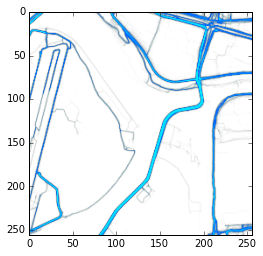

In [3]:
plt.imshow(getTile(4948, 2560, 13))
plt.show()

Качаем тайлы для Москвы, прости Старава.

In [53]:
zoom = 13
xmin, ymax = deg2num(55.55, 37.3, zoom)
xmax, ymin = deg2num(55.90, 37.93, zoom)
print xmin, xmax
print ymin, ymax
total = (xmax - xmin) * (ymax - ymin)
for x in xrange(xmin, xmax + 1):
    for y in xrange(ymin, ymax + 1):
        progress = (ymax - ymin) * (x - xmin) + y - ymin
        progress = float(progress) / total
        if int(progress * 100) % 10 == 0:
            print progress
        tile = getTile(x, y, z)
        imsave('tiles/%d_%d_%d.png' % (x, y, z), tile)

4944 4959
2554 2569
0.0
0.00444444444444
0.00888888888889
0.102222222222
0.106666666667
0.2
0.2
0.204444444444
0.208888888889
0.302222222222
0.306666666667
0.4
0.4
0.404444444444
0.408888888889
0.502222222222
0.506666666667
0.6
0.6
0.604444444444
0.608888888889
0.702222222222
0.706666666667
0.8
0.8
0.804444444444
0.808888888889
0.902222222222
0.906666666667
1.0
1.0
1.00444444444
1.00888888889


In [43]:

def getStravaWeight(lon_deg, lat_deg):
    zoom = 13
    n = 2.0 ** zoom
    lat_rad = math.radians(lat_deg)
    
    px, tile_x = math.modf((lon_deg + 180.0) / 360.0 * n)
    px = int(256 * px)
    py, tile_y = math.modf((1.0 - math.log(math.tan(lat_rad) + (1 / math.cos(lat_rad))) / math.pi) / 2.0 * n)
    py = int(256 * py)
    
    tile = imread('tiles/%d_%d_%d.png' % (tile_x, tile_y, zoom))
    gray = rgb2gray(tile)
#     plt.imshow(tile)
#     plt.imshow(gray)
#     print px, py
    return gray[py, px] / 256
    


    
getStravaWeight(37.46997, 55.74345)

0.35897656249999998

0 0.630178611288
1 0.635428838315
2 0.66394140625
3 0.439018156829
4 0.555826359161
5 0.634069620448
6 0.661574470766
7 0.4690390625
8 0.0516637228261
9 0.179318359375
10 0.23137109375
11 0.410732142857
12 0.44965078125
13 0.4532634375
14 0.602604492188
15 0.613991870777
16 0.356295386905
17 0.465727022059
18 0.6708203125
19 0.5836875
20 0.6708203125
21 0.6708203125
22 0.59606953125
23 0.5429134375
24 0.663588641827
25 0.277002929687
26 0.661698832418
27 0.599209134615
28 0.3144296875
29 0.439759615385
30 0.595986150568
31 0.283410546875
32 0.321976384943
33 0.474771484375
34 0.238677664621
35 0.401926192434
36 0.396169401042
37 0.393440104167
38 0.0870444711538
39 0.27184375
40 0.262966899671
41 0.138829808728
42 Cannot weight 42
[Errno 2] No such file or directory: 'tiles/4950_2553_13.png'
43 0.414294433594
44 0.46026252694
45 0.59515234375
46 0.505550180288
47 0.27872265625
48 0.383859519676


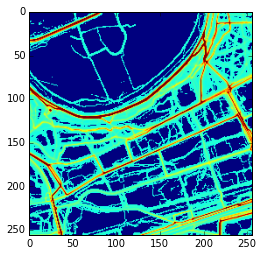

In [42]:
def parseRoads(filename='data/roads.csv'):
    """
        Generate list of [(Lat, Lon),...] roads
    """
    df = pd.read_csv(filename)
    roads = []
    for x in df['Track']:
        line = []
        for pair in x.split(';'):
            line.append(tuple([float(t) for t in pair.split(',')]))
        roads.append(line)
    return roads

def weightTheRoad(road):
    w = []
    for lon, lat in road:
        w.append(getStravaWeight(lon, lat))
    return sum(w) / len(road)

        
roads = parseRoads()

for i, road in enumerate(roads):
    try:
        print i, weightTheRoad(road)
    except Exception, err:
        print "Cannot weight %d" % i
        print err